# Breast Cancer

Goals: Analyse breast cancer medical data and create a model to predict diagnosis (benign or malignant tumor).

Methods:
 - Check and visualize feature correlations
 - Use Adaboost and XGBoost on the ‘Breast Cancer’ dataset to predict a diagnosis
 - Find most important features
 - Further tune hyperparameters with random and grid search

## workflow 

- clean dataset
- remove or replace NaN
- check features and target
- is the dataset balanced?
- drop useless features
- split test/train and y
- no scaling in random forest -> it doesn't care
- merge all back
- train models: Adaboost and XGBoost
- find best model
- use test set on best model, get prediction
- metrics

## The dataset

Attribute information

ID number
Diagnosis (M = malignant, B = benign)
Ten real-valued features are computed for each cell nucleus:
- radius (mean of distances from center to points on the perimeter)
- texture (standard deviation of gray-scale values)
- perimeter
- area
- smoothness (local variation in radius lengths)
- compactness (perimeter^2 / area - 1.0)
- concavity (severity of concave portions of the contour)
- concave points (number of concave portions of the contour)
- symmetry
- fractal dimension (“coastline approximation” - 1)

## Libraries

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV # for random search
from sklearn.model_selection import GridSearchCV # for grid search

# models
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score
import seaborn as sns
import pprint # for nicer printing
from sklearn.metrics import accuracy_score

## Data exploration and preparation 

In [41]:
bc_data = pd.read_csv('data-breast-cancer.csv', delimiter=",")

In [42]:
bc_data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [43]:
bc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
id                         569 non-null int64
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non

- id is not useful (identifies case only)
- The target is "diagnosis" (object type)
- The features are everything else (float) --> no onehot encoding needed

In [44]:
# there is the Unnamed: 32 column that is empty: drop
bc_data=bc_data.drop(columns=["Unnamed: 32"])

In [45]:
# drop id
bc_data=bc_data.drop(columns=["id"])

In [46]:
bc_data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Investigate features and target

In [47]:
# how balanced is it?
# B: benign, M: malignant

bc_data["diagnosis"].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

It's somewhat unbalanced. There are (luckily) more benign tha malignant tumors

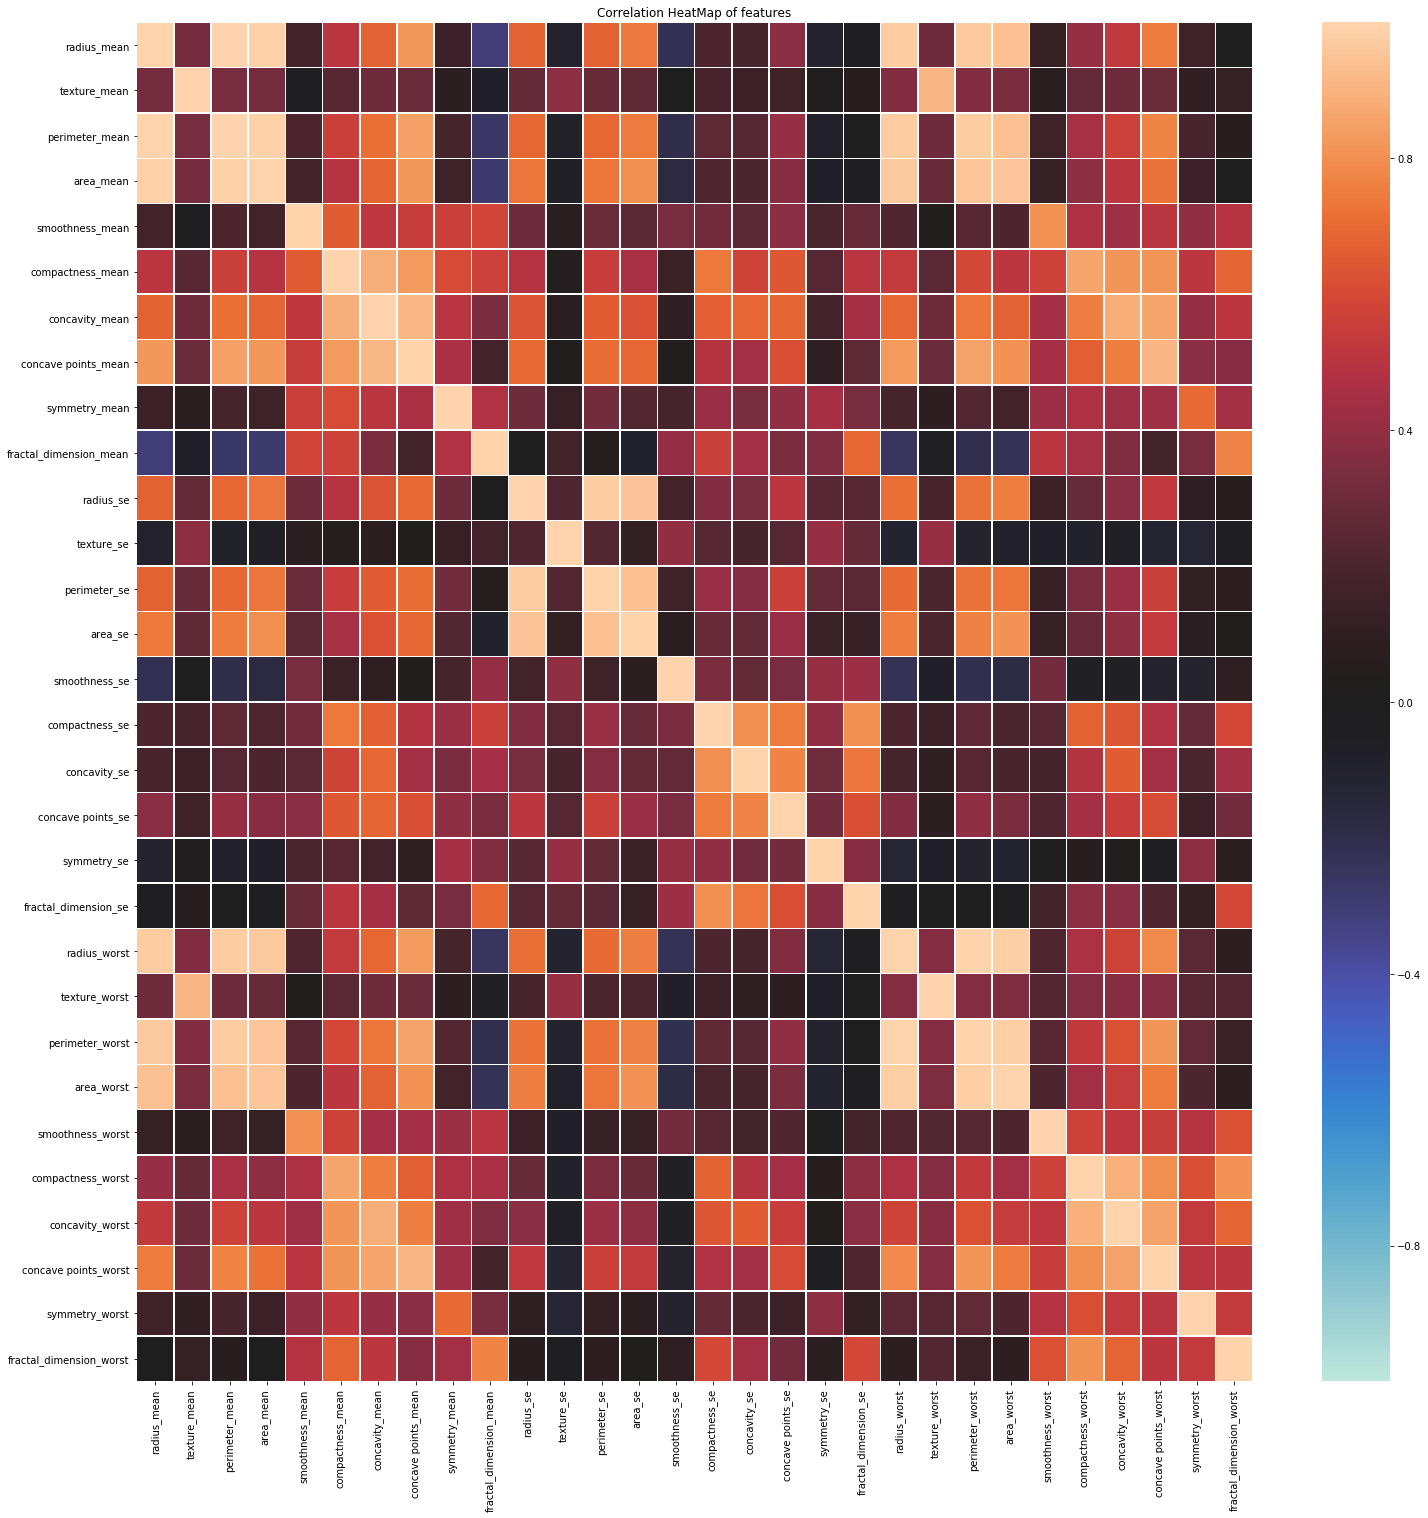

In [48]:
# creating pairwise correlation of columns using Pearson's R,
corr = bc_data.loc[:, bc_data.columns != 'diagnosis'].corr(method='pearson')


# plotting the correlation coefficients on a seasborn heatmap matrix
fig, ax = plt.subplots(figsize=(25, 25))
sns.heatmap(corr, annot=False, xticklabels=corr.columns,
            yticklabels=corr.columns, ax=ax, linewidths=.5,
            vmin=-1, vmax=1, center=0)

plt.title('Correlation HeatMap of features')
plt.show()

# many features seem to be correlated with each other

Many features are highly positively correlated as they basically build on each other.

E.g. radius/perimeter/area --> only use one

## First model: forest with ALL features

In [49]:
# split into X and y

X_all = bc_data.drop(columns=["diagnosis"])

y_raw_all = bc_data["diagnosis"]
y_all = pd.DataFrame({"Outcome":y_raw_all }) # Outcome is the new column title

y_all[y_all=="B"]=0.0 # benign: non-event
y_all[y_all=="M"]=1.0 #malignant: event

# y is currently of object type

# cast y as int

y_all=y_all.astype("int")
y_all.info()

# test/train split
# these are the final sets as no conversion(encoding) is needed; all are digits
# no scaling is needed in random forests

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all,
                                                    y_all,
                                                    test_size=.30,
                                                    random_state=0)

clf_all = RandomForestClassifier(bootstrap=True, class_weight="balanced_subsample", criterion='gini',
                             max_depth=4, min_samples_split=10, n_estimators=100, n_jobs=5, oob_score=False, random_state=None, warm_start=False).fit(X_train_all, y_train_all.Outcome)

clf_all.score(X_train_all, y_train_all.Outcome)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 1 columns):
Outcome    569 non-null int64
dtypes: int64(1)
memory usage: 4.5 KB


0.9899497487437185

In [50]:
X_all.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [51]:
importances_all = pd.DataFrame(clf_all.feature_importances_)

importances_all.columns = ['importance']  # rename column

importances_all["feature"] = X_train_all.columns  # add features as second column

importances_all = importances_all[["feature", 'importance']]

importances_all.sort_values(by='importance', ascending=False)

,feature,importance
27,concave points_worst,0.158264
7,concave points_mean,0.133366
22,perimeter_worst,0.123614
20,radius_worst,0.083248
6,concavity_mean,0.077462
23,area_worst,0.068455
13,area_se,0.055451
2,perimeter_mean,0.052811
26,concavity_worst,0.036716
3,area_mean,0.036302


## Cleaning of data (remove redundant/correlated features) 

In [52]:
# remove most standard error columns
bc_data = bc_data.drop(columns=["symmetry_mean","radius_se",
                                "texture_se",
                                "perimeter_se",
                                "area_se",
                                "smoothness_se",
                                "compactness_se",
                                "concavity_se",
                                "concave points_se",
                                "symmetry_se",
                                "fractal_dimension_se"])

    
bc_data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,fractal_dimension_mean,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.07871,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.05667,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.05999,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.09744,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.05883,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [53]:
# remove all standard error columns
bc_data = bc_data.drop(columns=[
                       "perimeter_mean", "area_mean", "radius_worst", "perimeter_worst",  "texture_worst", "concave points_mean"])


#remove unneccessary features
bc_data = bc_data.drop(columns=["fractal_dimension_mean"])

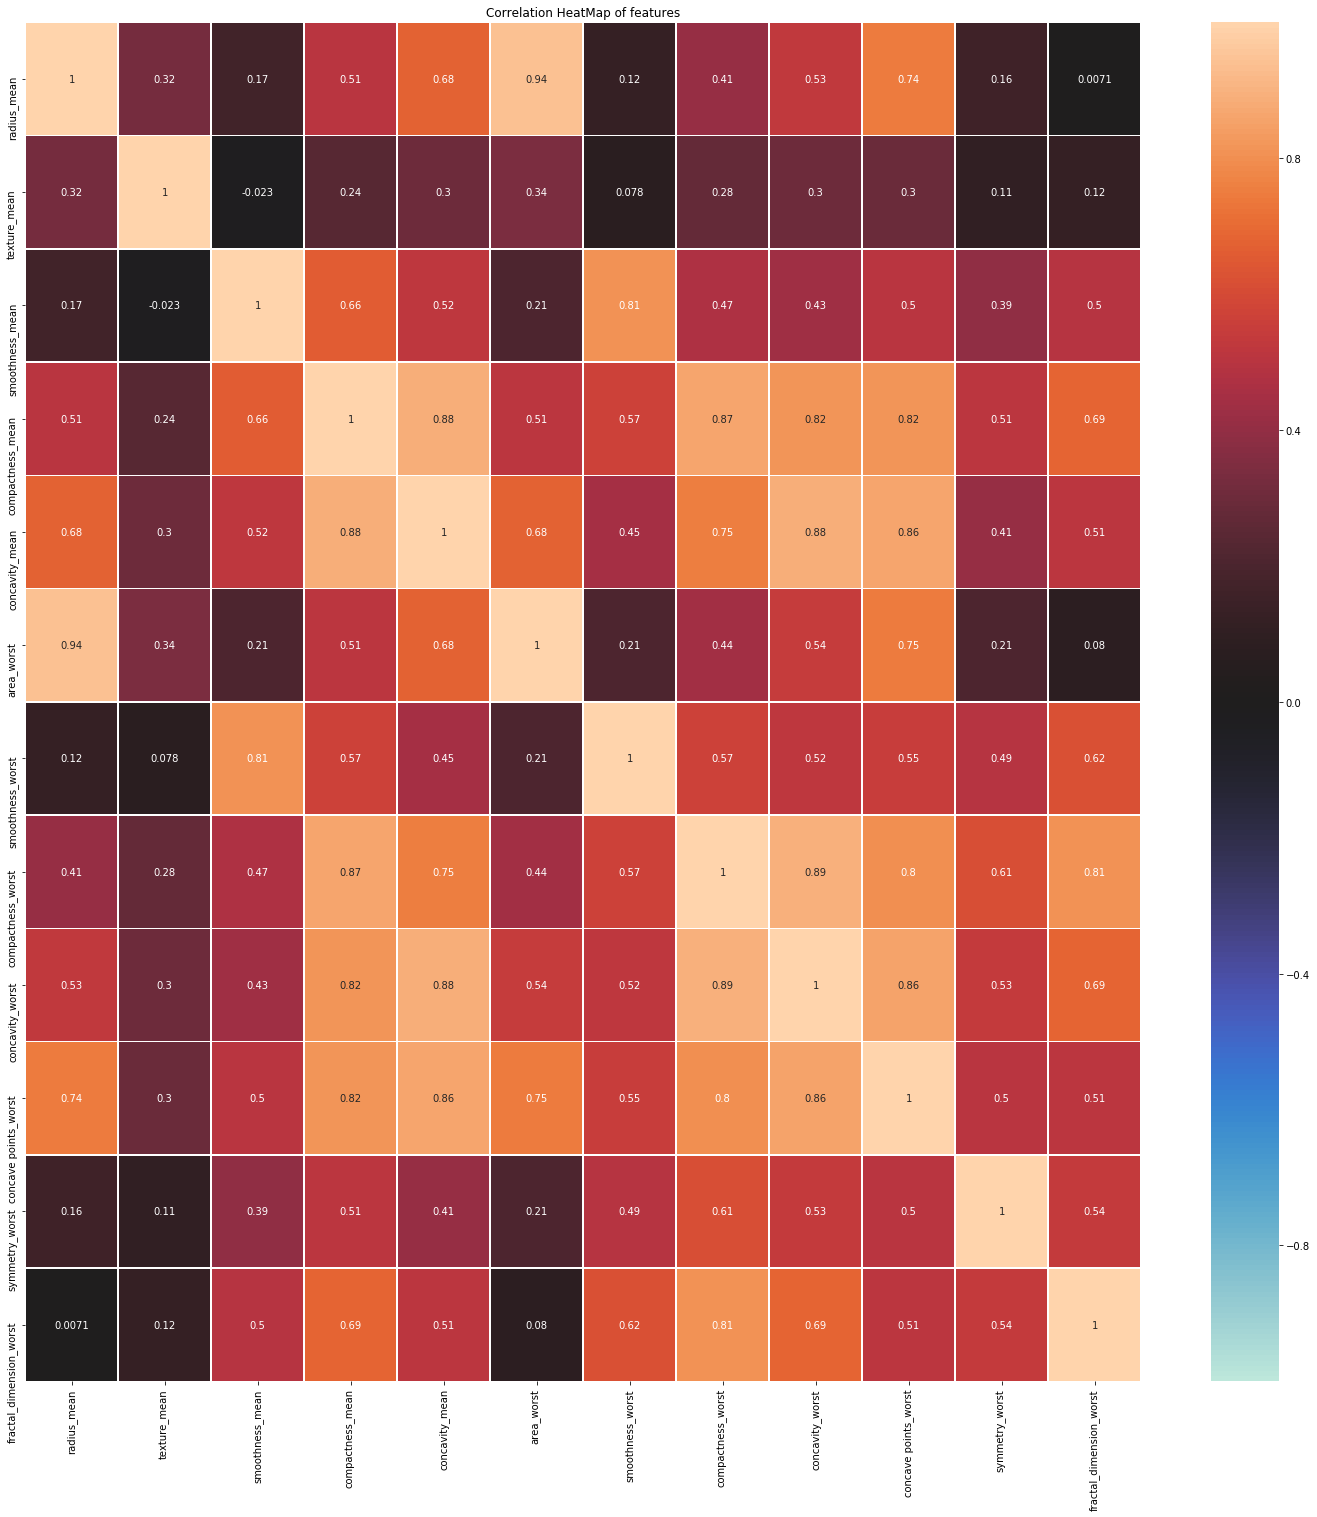

In [54]:
# final heatmap

corr = bc_data.loc[:, bc_data.columns != 'diagnosis'].corr(method='pearson')


# plotting the correlation coefficients on a seasborn heatmap matrix
fig, ax = plt.subplots(figsize=(25, 25))
sns.heatmap(corr, annot=True, xticklabels=corr.columns,
            yticklabels=corr.columns, ax=ax, linewidths=.5,
            vmin=-1, vmax=1, center=0)

plt.title('Correlation HeatMap of features')
plt.show()

# now nothing over .89 correlation left

## X, y split (of whole dataset)

In [55]:
# split into X and y

X = bc_data.drop(columns=["diagnosis"])

y_raw = bc_data["diagnosis"]
y = pd.DataFrame({"Outcome":y_raw }) # Outcome is the new column title

y[y=="B"]=0.0 # benign: non-event
y[y=="M"]=1.0 #malignant: event

# y is currently of object type

In [56]:
# cast y as int

y=y.astype("int")
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 1 columns):
Outcome    569 non-null int64
dtypes: int64(1)
memory usage: 4.5 KB


In [57]:
# test/train split
# these are the final sets as no conversion(encoding) is needed; all are digits
# no scaling is needed in random forests

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.30,
                                                    random_state=0)


X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=.30,
                                                    random_state=0)


In [58]:
X_train.head()

,radius_mean,texture_mean,smoothness_mean,compactness_mean,concavity_mean,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
149,13.74,17.91,0.07944,0.06376,0.02881,725.9,0.09711,0.1824,0.15640,0.06019,0.2350,0.07014
442,13.78,15.79,0.08817,0.06718,0.01055,706.6,0.10720,0.1071,0.03517,0.03312,0.1859,0.06810
365,20.44,21.78,0.09150,0.11310,0.09799,1780.0,0.13270,0.2376,0.27020,0.17650,0.2609,0.06735
474,10.88,15.62,0.10070,0.10690,0.05115,433.1,0.13320,0.3898,0.33650,0.07966,0.2581,0.10800
19,13.54,14.36,0.09779,0.08129,0.06664,711.2,0.14400,0.1773,0.23900,0.12880,0.2977,0.07259


In [59]:
y_train.head()

,Outcome
149,0
442,0
365,1
474,0
19,0


## "Best" model from Friday (with val outcome)

In [60]:
RF_best = RandomForestClassifier(bootstrap=True, class_weight="balanced_subsample", criterion='entropy',
                                 max_depth=20, min_samples_split=10, n_estimators=1000, n_jobs=5, oob_score=False,
                                 random_state=None, warm_start=False).fit(X_train, y_train.Outcome)

RF_best_scores = cross_val_score(RF_best, X_train, y_train.Outcome, cv=5)
print("5-fold cross validation score: " + str(RF_best_scores.mean()))

5-fold cross validation score: 0.9496058327637276


In [61]:
RF_best.score(X_train, y_train.Outcome)

importances_RF_best = pd.DataFrame(RF_best.feature_importances_)

importances_RF_best.columns = ['importance']  # rename column

importances_RF_best["feature"] = X_train.columns  # add features as second column

importances_RF_best = importances_RF_best[["feature", 'importance']]

importances_RF_best.sort_values(by='importance', ascending=False)

,feature,importance
9,concave points_worst,0.244785
5,area_worst,0.212876
4,concavity_mean,0.147630
0,radius_mean,0.115449
8,concavity_worst,0.097547
3,compactness_mean,0.039736
1,texture_mean,0.036572
7,compactness_worst,0.035799
10,symmetry_worst,0.022993
6,smoothness_worst,0.019083


In [62]:
# show how it performs on test data


predictions_RF=RF_best.predict(X_val)

# accuracy = accuracy_score(y_test, predictions_RF)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

confusion_RF=pd.DataFrame(confusion_matrix(y_val, predictions_RF))


Precision = confusion_RF.loc[1, 1]/(confusion_RF.loc[1, 1]+confusion_RF.loc[1, 0])*100

ER = (confusion_RF.loc[1, 0]+confusion_RF.loc[0, 1])/(confusion_RF.loc[1, 1] +
      confusion_RF.loc[1, 0]+confusion_RF.loc[0, 1]+confusion_RF.loc[0, 0])*100

Accuracy = (confusion_RF.loc[1,1]+confusion_RF.loc[0,0])/(confusion_RF.loc[1, 1] +
      confusion_RF.loc[1, 0]+confusion_RF.loc[0, 1]+confusion_RF.loc[0, 0])*100

print("Accuracy ((TP+TN)/all): " + str(round(Accuracy, 2)) + "%")

print("Precision (TP/(TP+FN)): " + str(round(Precision, 2)) + "%")

print("Error Rate ((FP+FN)/all): " + str(round(ER, 2)) + "%")

confusion_RF

Accuracy ((TP+TN)/all): 95.83%
Precision (TP/(TP+FN)): 97.62%
Error Rate ((FP+FN)/all): 4.17%


,0,1
0,74,4
1,1,41


## Use AdaClassifier (with val outcome)

In [74]:
# Fit a AdaBoost model, compare it to RF_best

ada_clf = AdaBoostClassifier(n_estimators=800,
                             learning_rate=0.8,
                             random_state=0)

ada_clf.fit(X_train, y_train.Outcome)

ada_clf_scores = cross_val_score(ada_clf, X_train, y_train.Outcome, cv=5)
print("5-fold cross validation score: " + str(ada_clf_scores.mean()))

importances_ada = pd.DataFrame(ada_clf.feature_importances_)

importances_ada.columns = ['importance']  # rename column

importances_ada["feature"] = X_train.columns  # add features as second column

importances_ada = importances_ada[["feature", 'importance']]

importances_ada.sort_values(by='importance', ascending=False)

5-fold cross validation score: 0.9605172020961493


,feature,importance
5,area_worst,0.14875
3,compactness_mean,0.13375
2,smoothness_mean,0.11125
1,texture_mean,0.10875
6,smoothness_worst,0.10875
11,fractal_dimension_worst,0.10375
9,concave points_worst,0.07375
10,symmetry_worst,0.06750
4,concavity_mean,0.05750
8,concavity_worst,0.04750


In [75]:
predictions_ada = ada_clf.predict(X_val)

accuracy = accuracy_score(y_val.Outcome, predictions_ada)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

confusion_ada = pd.DataFrame(confusion_matrix(y_val.Outcome, predictions_ada))

Precision = confusion_ada.loc[1, 1]/(confusion_ada.loc[1, 1]+confusion_ada.loc[1, 0])*100

ER = (confusion_ada.loc[1, 0]+confusion_ada.loc[0, 1])/(confusion_ada.loc[1, 1] +
      confusion_ada.loc[1, 0]+confusion_ada.loc[0, 1]+confusion_ada.loc[0, 0])*100

Accuracy = (confusion_ada.loc[1,1]+confusion_ada.loc[0,0])/(confusion_ada.loc[1, 1] +
      confusion_ada.loc[1, 0]+confusion_ada.loc[0, 1]+confusion_ada.loc[0, 0])*100

print("Accuracy ((TP+TN)/all): " + str(round(Accuracy, 2)) + "%")

print("Precision (TP/(TP+FN)): " + str(round(Precision, 2)) + "%")

print("Error Rate ((FP+FN)/all): " + str(round(ER, 2)) + "%")



confusion_ada

Accuracy: 96.67%
Accuracy ((TP+TN)/all): 96.67%
Precision (TP/(TP+FN)): 97.62%
Error Rate ((FP+FN)/all): 3.33%


,0,1
0,75,3
1,1,41


## Use XGBoost (with val outcome)

In [87]:
xgb_clf = XGBClassifier(max_depth=2, n_estimators=800, learning_rate=0.3)
xgb_clf.fit(X_train, y_train.Outcome)

xgb_clf_scores = cross_val_score(xgb_clf, X_train, y_train.Outcome, cv=5)
print("5-fold cross validation score: " + str(xgb_clf_scores.mean()))

importances_xgb = pd.DataFrame(xgb_clf.feature_importances_)

importances_xgb.columns = ['importance']  # rename column

importances_xgb["feature"] = X_train.columns  # add features as second column

importances_xgb = importances_xgb[["feature", 'importance']]

importances_xgb.sort_values(by='importance', ascending=False)

5-fold cross validation score: 0.9640236956026429


,feature,importance
9,concave points_worst,0.727644
5,area_worst,0.096231
4,concavity_mean,0.078582
1,texture_mean,0.027455
3,compactness_mean,0.021974
0,radius_mean,0.020242
10,symmetry_worst,0.012788
2,smoothness_mean,0.006687
11,fractal_dimension_worst,0.003081
6,smoothness_worst,0.002420


In [88]:

predictions_gxb = xgb_clf.predict(X_val)

# evaluate predictions
confusion_gxb = pd.DataFrame(confusion_matrix(y_val.Outcome, predictions_gxb))


Precision = confusion_gxb.loc[1, 1]/(confusion_gxb.loc[1, 1]+confusion_gxb.loc[1, 0])*100

ER = (confusion_gxb.loc[1, 0]+confusion_gxb.loc[0, 1])/(confusion_gxb.loc[1, 1] +
      confusion_gxb.loc[1, 0]+confusion_gxb.loc[0, 1]+confusion_gxb.loc[0, 0])*100

Accuracy = (confusion_gxb.loc[1,1]+confusion_gxb.loc[0,0])/(confusion_gxb.loc[1, 1] +
      confusion_gxb.loc[1, 0]+confusion_gxb.loc[0, 1]+confusion_gxb.loc[0, 0])*100

print("Accuracy ((TP+TN)/all): " + str(round(Accuracy, 2)) + "%")

print("Precision (TP/(TP+FN)): " + str(round(Precision, 2)) + "%")

print("Error Rate ((FP+FN)/all): " + str(round(ER, 2)) + "%")

confusion_gxb

Accuracy ((TP+TN)/all): 97.5%
Precision (TP/(TP+FN)): 97.62%
Error Rate ((FP+FN)/all): 2.5%


,0,1
0,76,2
1,1,41


XGBoost is the best model, both in terms of precision and accuracy. It also has the best 5-fold CV score.

Adaboost is the worst in predicting.

Top features: 

RF_best: 

- 9 	concave points_worst(0.263591)
- 5 	area_worst (0.207616)
- 4 	concavity_mean (0.145505)

ada_clf:

- 5 	area_worst (0.21)
- 1 	texture_mean (0.15)
- 2 	smoothness_mean (0.15)

gxb_clf:

- 9 	concave points_worst (0.498072)
- 4 	concavity_mean (0.177725)
- 5 	area_worst (0.122458)

## The final thing with XGBoost

In [89]:

predictions_gxb_test = xgb_clf.predict(X_test)

# evaluate predictions
confusion_gxb_test = pd.DataFrame(confusion_matrix(y_test.Outcome, predictions_gxb_test))


Precision = confusion_gxb_test.loc[1, 1]/(confusion_gxb_test.loc[1, 1]+confusion_gxb_test.loc[1, 0])*100

ER = (confusion_gxb_test.loc[1, 0]+confusion_gxb_test.loc[0, 1])/(confusion_gxb_test.loc[1, 1] +
      confusion_gxb_test.loc[1, 0]+confusion_gxb_test.loc[0, 1]+confusion_gxb_test.loc[0, 0])*100

Accuracy = (confusion_gxb_test.loc[1,1]+confusion_gxb_test.loc[0,0])/(confusion_gxb_test.loc[1, 1] +
      confusion_gxb_test.loc[1, 0]+confusion_gxb_test.loc[0, 1]+confusion_gxb_test.loc[0, 0])*100

print("Accuracy ((TP+TN)/all): " + str(round(Accuracy, 2)) + "%")

print("Precision (TP/(TP+FN)): " + str(round(Precision, 2)) + "%")

print("Error Rate ((FP+FN)/all): " + str(round(ER, 2)) + "%")

confusion_gxb_test

Accuracy ((TP+TN)/all): 96.49%
Precision (TP/(TP+FN)): 96.83%
Error Rate ((FP+FN)/all): 3.51%


,0,1
0,104,4
1,2,61
